![](img/banner_protein.jpg)

# Multi-label Classification: Human Protein

## Overview

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [10]:
plt.style.use(['dark_background'])

In [2]:
from utils import open_4_channel
from resnet import Resnet4Channel

In [12]:
bs = 64

In [13]:
path = Path('data/competitions/protein/')

In [14]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [15]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

In [16]:
src.train.x.create_func = open_4_channel

In [17]:
src.valid.x.create_func = open_4_channel

In [18]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [19]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [20]:
test_fnames[:5]

[PosixPath('data/competitions/protein/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/competitions/protein/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/competitions/protein/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/competitions/protein/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/competitions/protein/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [21]:
src.add_test(test_fnames, label='0')

LabelLists;
Train: LabelList
y: MultiCategoryList (24858 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 18]...
Path: .
x: ImageItemList (24858 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/competitions/protein;
Valid: LabelList
y: MultiCategoryList (6214 items)
[MultiCategory 12;23;0, MultiCategory 0, MultiCategory 1;0, MultiCategory 25;5, MultiCategory 23]...
Path: .
x: ImageItemList (6214 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/competitions/protein;
Test: LabelList
y: MultiCategoryList (11702 items)
[MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0]...
Path: .
x: ImageItemList (11702 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/competitions/protein

In [22]:
src.test.x.create_func = open_4_channel

In [23]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [24]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [25]:
data = (src.transform((trn_tfms, _), size=224)
        .databunch().normalize(protein_stats))

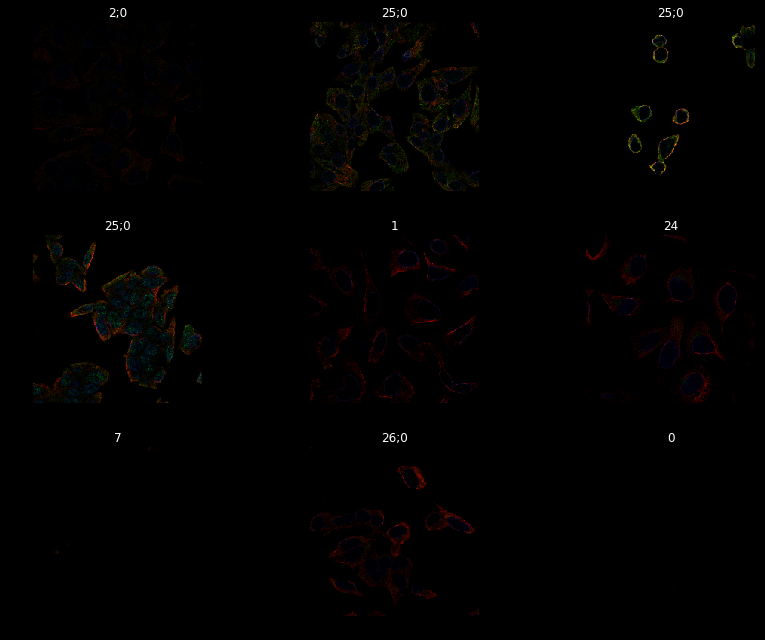

In [26]:
data.show_batch(rows=3, figsize=(12,9))

In [27]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [28]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6],m[1])

In [29]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [30]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


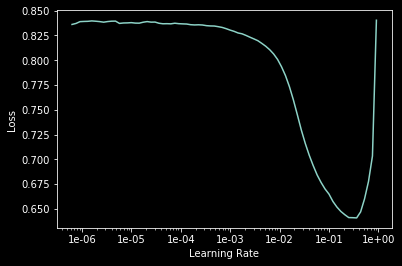

In [32]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [33]:
lr = 3e-2

In [34]:
learn.fit_one_cycle(5, slice(lr))

Total time: 10:44
epoch  train_loss  valid_loss  fbeta   
1      0.136042    0.138752    0.495030  (02:10)
2      0.149942    0.163156    0.498886  (02:08)
3      0.131566    0.851650    0.544176  (02:08)
4      0.118687    0.196012    0.594817  (02:07)
5      0.113867    0.576766    0.617613  (02:08)



In [35]:
learn.save('stage-1-rn50-datablocks')

In [41]:
learn.load('stage-1-rn50-datablocks');

In [42]:
learn.unfreeze()

In [43]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


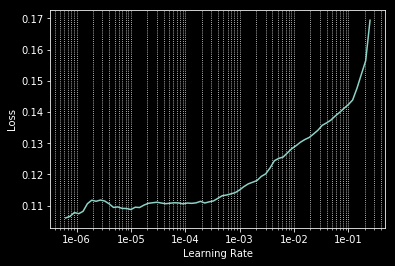

In [47]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [48]:
learn.fit_one_cycle(15, slice(2e-6, lr/5))

Total time: 37:51
epoch  train_loss  valid_loss  fbeta   
1      0.112064    0.139033    0.620703  (02:31)
2      0.110544    0.215082    0.619766  (02:31)
3      0.110530    0.226218    0.622201  (02:31)
4      0.108392    0.178095    0.613285  (02:30)
5      0.108976    0.139517    0.632180  (02:31)
6      0.105237    0.160948    0.626198  (02:31)
7      0.105603    0.216943    0.640156  (02:31)
8      0.101180    0.126620    0.660388  (02:31)
9      0.098020    0.187793    0.655213  (02:31)
10     0.098735    0.939234    0.658242  (02:31)
11     0.094884    0.105314    0.674148  (02:31)
12     0.092047    0.123969    0.679105  (02:31)
13     0.090361    0.123418    0.683959  (02:31)
14     0.088654    0.113762    0.686785  (02:31)
15     0.087834    0.120293    0.684827  (02:31)



In [31]:
learn.save('stage-2-rn50')

In [49]:
preds,_ = learn.get_preds(DatasetType.Test)

/opt/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [50]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)

In [53]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f {path}/protein_predictions_datablocks.csv -m "Submit for sanity check"

100%|████████████████████████████████████████| 483k/483k [00:09<00:00, 50.0kB/s]
Successfully submitted to Human Protein Atlas Image Classification